In [11]:
%reset -f

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import ee
ee.Authenticate()


Mounted at /content/drive


In [ ]:
import ee

ee.Initialize(project='ee-andrewfullhart')

point = ee.Geometry.Point(-110.64, 31.79)
climate_model = 'MIROC5'

maca_ic = ee.ImageCollection('IDAHO_EPSCOR/MACAv2_METDATA')
maca_ic = maca_ic.filter(ee.Filter.date('1981-01-01', '2100-01-1'))
modelfilter = ee.Filter.Or(
              ee.Filter.eq('scenario', 'historical'),
              ee.Filter.eq('scenario', 'rcp45'))
maca_ic = maca_ic.filter(modelfilter)
maca_ic = maca_ic.filter(ee.Filter.eq('model', climate_model))

prop_list = maca_ic.getRegion(point, 100)

def calc_kmd_wind_from_uv_ms(u, v):
  u = ee.Number(u)
  v = ee.Number(v)
  ms = u.pow(2.0).add(v.pow(2.0)).pow(0.5)
  kmd = ms.multiply(86400.0).divide(1000.0)
  return kmd

def calc_rh_from_sh(sh, tmax, tmin):
  sh = ee.Number(sh)
  tmax = ee.Number(tmax)
  tmin = ee.Number(tmin)
  tavg = tmax.add(tmin).divide(2.0)
  rh = sh.divide(ee.Number(2.541e6).multiply(ee.Number(-5415.0).divide(tavg).exp()).multiply(ee.Number(18.0).divide(29.0))).multiply(100.0)
  return rh

def props_fn(props):
  props = ee.List(props)
  time = ee.String(props.get(0)).split('_').get(2)
  pr = ee.Number(props.get(5))
  tasmax = ee.Number(props.get(8)).subtract(273.15)
  tasmin = ee.Number(props.get(7)).subtract(273.15)
  rsds = ee.Number(props.get(6)).multiply(86400.0).divide(1e6)
  u = ee.Number(props.get(9))
  v = ee.Number(props.get(10))
  wspd = ee.Number(calc_kmd_wind_from_uv_ms(u, v))

  #rh = ee.Number(calc_rh_from_sh(ee.Number(props.get(4)), ee.Number(props.get(8)), ee.Number(props.get(7))))
  rh = ee.Number(ee.Number(props.get(11)).add(props.get(12))).divide(2.0);
  return ee.Feature(None,
             {'time':time,
              'pr':pr,
              'tmax':tasmax,
              'tmin':tasmin,
              'srad':rsds,
              'rh':rh,
              'wspd':wspd
              })

tableFeat = ee.FeatureCollection(prop_list.slice(1).map(props_fn))

task = ee.batch.Export.table.toDrive(collection=tableFeat,
                               folder='GEE_downloads',
                               description='timeseries',
                               selectors=['time', 'pr', 'tmax', 'tmin', 'srad', 'rh', 'wspd'])

task.start()




In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import os

dataFILE = '/content/drive/My Drive/Colab Notebooks/Empire/CCSM4_timeseries.csv'
outFOLDER = '/content/drive/My Drive/Colab Notebooks/Empire'
df = pd.read_csv(dataFILE)
df['year'] = df['time'].apply(lambda x:int(str(x)[:4]))
df['month'] = df['time'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['time'].apply(lambda x:int(str(x)[6:8]))

print(df)

days_rec_len = 43464
elev = 1400
scf = 0.3
coords = {'longitude':-110.64264, 'latitude' : 31.78581}

import math

class Sun:

  def getSunriseTime(self, date, coords):
    return self.calcSunTime(date, coords, True)

  def getSunsetTime(self, date, coords):
    return self.calcSunTime(date, coords, False)

  def calcSunHours(self, date, coords):
    sr = self.getSunriseTime(date, coords)['decimal']
    ss = self.getSunsetTime(date, coords)['decimal']
    if sr > ss:
      sunhrs = 24 - sr + ss
    else:
      sunhrs = ss - sr
    return sunhrs

  def calcSunTime(self, date, coords, isRiseTime, zenith = 90.8):

    # isRiseTime == False, returns sunsetTime

    longitude = coords['longitude']
    latitude = coords['latitude']

    TO_RAD = math.pi/180

    #1. first calculate the day of the year
    N = self.getJDay(date)

    #2. convert the longitude to hour value and calculate an approximate time
    lngHour = longitude / 15

    if isRiseTime:
        t = N + ((6 - lngHour) / 24)
    else: #sunset
        t = N + ((18 - lngHour) / 24)

    #3. calculate the Sun's mean anomaly
    M = (0.9856 * t) - 3.289

    #4. calculate the Sun's true longitude
    L = M + (1.916 * math.sin(TO_RAD*M)) + (0.020 * math.sin(TO_RAD * 2 * M)) + 282.634
    L = self.forceRange( L, 360 ) #NOTE: L adjusted into the range [0,360)

    #5a. calculate the Sun's right ascension

    RA = (1/TO_RAD) * math.atan(0.91764 * math.tan(TO_RAD*L))
    RA = self.forceRange( RA, 360 ) #NOTE: RA adjusted into the range [0,360)

    #5b. right ascension value needs to be in the same quadrant as L
    Lquadrant  = (math.floor( L/90)) * 90
    RAquadrant = (math.floor(RA/90)) * 90
    RA = RA + (Lquadrant - RAquadrant)

    #5c. right ascension value needs to be converted into hours
    RA = RA / 15

    #6. calculate the Sun's declination
    sinDec = 0.39782 * math.sin(TO_RAD*L)
    cosDec = math.cos(math.asin(sinDec))

    #7a. calculate the Sun's local hour angle
    cosH = (math.cos(TO_RAD*zenith) - (sinDec * math.sin(TO_RAD*latitude))) / (cosDec * math.cos(TO_RAD*latitude))

    if cosH > 1:
        return {'status': False, 'msg': 'the sun never rises on this location (on the specified date)'}

    if cosH < -1:
        return {'status': False, 'msg': 'the sun never sets on this location (on the specified date)'}

    #7b. finish calculating H and convert into hours

    if isRiseTime:
        H = 360 - (1/TO_RAD) * math.acos(cosH)
    else: #setting
        H = (1/TO_RAD) * math.acos(cosH)

    H = H / 15

    #8. calculate local mean time of rising/setting
    T = H + RA - (0.06571 * t) - 6.622

    #9. adjust back to UTC
    UT = T - lngHour
    UT = self.forceRange( UT, 24) # UTC time in decimal format (e.g. 23.23)

    #10. Return
    hr = self.forceRange(int(UT), 24)
    min = round((UT - int(UT))*60,0)

    return {
        'status': True,
        'decimal': UT,
        'hr': hr,
        'min': min
    }

  def calcSunRadET(self, date, coords):
    latitude = coords['latitude']
    latrad = latitude * (np.pi/180.0)
    N = self.getJDay(date)
    dec = 0.409*np.sin(((2*np.pi/365)*N)-1.39)
    hranglSS = np.arccos(-np.tan(latrad)*np.tan(dec))
    dist = 1 + (0.033*np.cos((2*np.pi/365)*N))
    radET = (1360/np.pi)*(dist)*((hranglSS*np.sin(latrad)*np.sin(dec)) + (np.cos(latrad)*np.cos(dec)*np.sin(hranglSS)))
    return radET

  def getJDay(self, date):
    day = date['day']
    month = date['month']
    year = date['year']
    N1 = math.floor(275 * month / 9)
    N2 = math.floor((month + 9) / 12)
    N3 = (1 + math.floor((year - 4 * math.floor(year / 4) + 2) / 3))
    N = N1 - (N2 * N3) + day - 30
    return N

  def forceRange(self, v, max):
    # force v to be >= 0 and < max
    if v < 0:
        return v + max
    elif v >= max:
        return v - max
    return v



header = """Pcp_File_Version=4
*** BLOCK I: ATMOSPHERIC INFORMATION  **********************************
   MaxAL                    (MaxAL = number of atmospheric data-records)
      {}
 DailyVar  SinusVar  lLay  lBCCycles lInterc lDummy  lDummy  lDummy  lDummy  lDummy
       t       t       f       f       f       f       f       f       f       f
 hCritS                 (max. allowed pressure head at the soil surface)
      0
       tAtm        Prec       rSoil       rRoot      hCritA          rB          hB          ht        tTop        tBot        Ampl    RootDepth\n""".format(str(days_rec_len))

footer = """end*** END OF INPUT FILE 'ATMOSPH.IN' *************************************"""

p_list = df['pr'].round(3)

fileName = 'ATMOSPH.IN'

day = 1

with open(os.path.join(outFOLDER, fileName), 'w') as fo:

  fo.write(header)

  for j in range(days_rec_len):

    fo.write(str(day).rjust(11) + str(p_list[j]).rjust(12) + '0'.rjust(12) + '0'.rjust(12) + '1e+006'.rjust(12) + '           0           0           0' + '15'.rjust(11) + '15'.rjust(11) + '0'.rjust(12) + '200'.rjust(12) + '\n')

    day += 1

  fo.write(footer)



srd_list = df['srad'].round(3)
tmx_list = df['tmax'].round(3)
tmn_list = df['tmin'].round(3)
rh_list = df['rh'].round(3)
wnd_list = df['wspd'].round(3)
sun = Sun()

elev = elev
shr_list = []
for index, item in df.iterrows():
  item['year']
  date = {'day': item['day'], 'month': item['month'], 'year': item['year']}
  shr = round(sun.calcSunHours(date, coords), 3)
  shr_list.append(shr)

fileName = 'METEO.IN'

day = 1

header = """Pcp_File_Version=4
* METEOROLOGICAL PARAMETERS AND INFORMATION |||||||||||||||||||||||||||||||
 MeteoRecords Radiation Penman-Hargreaves
        {}        1       f
  lEnBal  lDaily  lDummy  lDummy  lDummy  lDummy  lDummy  lDummy  lDummy  lDummy
       f       t       f       f       f       t       f       f       f       f
 Latitude  Altitude
  {}       {}
 ShortWaveRadA  ShortWaveRadB
          0.25            0.5
 LongWaveRadA   LongWaveRadB
           0.9            0.1
 LongWaveRadA1  LongWaveRadB1
          0.34         -0.139
 WindHeight     TempHeight
        200            200
 iCrop (=0: no crop, =1: constant, =2: table, =3: daily)  SunShine  RelativeHum
         1                                                3         0
  CloudFactAC    CloudFactBC
          1.35          -0.35
 iLai (=0: given, =1: grass, =2; alfalfa, =3: surface fraction)  rExtinct
    3                                                              0.463
 Interception
    0
CropHeight     Albedo        LAI      rRoot
       200       0.23        0.5          0
Daily values
       t        Rad        TMax        TMin     RHMean      Wind    SunHours CropHeight     Albedo   LAI(SCF)      rRoot
       [T]  [MJ/m2/d]       [C]         [C]       [%]     [km/d]     [hour]      [L]           [-]        [-]        [L]\n""".format(days_rec_len, coords['latitude'], elev)

footer = """end *** END OF INPUT FILE 'METEO.IN' **********************************"""

with open(os.path.join(outFOLDER, fileName), 'w') as fo:

  fo.write(header)

  for j in range(days_rec_len):
    srd = srd_list[j]
    tmx = tmx_list[j]
    tmn = tmn_list[j]
    rh = rh_list[j]
    wnd = wnd_list[j]
    shr = shr_list[j]

    fo.write(str(day).rjust(10) + str(srd).rjust(11) + str(tmx).rjust(11) + str(tmn).rjust(11) + str(rh).rjust(11) + str(wnd).rjust(11) + str(shr).rjust(11) + '\n')

    day += 1

  fo.write(footer)




           time        pr       tmax      tmin       srad         rh  \
0      19810101  0.000000  23.816248  3.465936  13.722762  19.749496   
1      19810102  0.000000  24.454645  3.667566  13.842164  17.453169   
2      19810103  0.000000  23.316705  2.126123  13.799121  15.608774   
3      19810104  0.000000  20.614648 -0.189246  14.213087  15.713135   
4      19810105  0.000000  15.052057 -2.127234  13.550418  17.227382   
...         ...       ...        ...       ...        ...        ...   
43459  20991227  1.329693  15.307092  2.913660  12.466899  69.069445   
43460  20991228  0.000000  16.231714  1.226312  11.987314  60.094808   
43461  20991229  0.000000  16.123407  1.002039  12.823316  56.978305   
43462  20991230  0.478874  15.915826  1.818292   8.441988  54.141428   
43463  20991231  0.490911  17.760370  4.427393   8.281366  65.885425   

             wspd  year  month  day  
0      183.189385  1981      1    1  
1      123.956421  1981      1    2  
2      130.263594  19

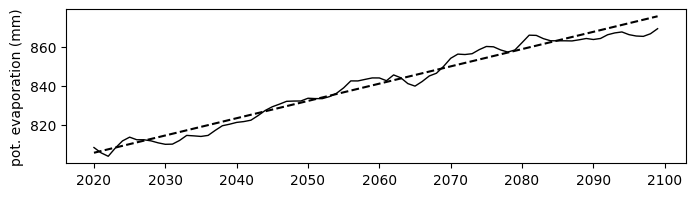

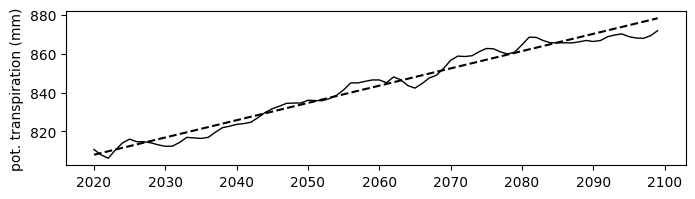

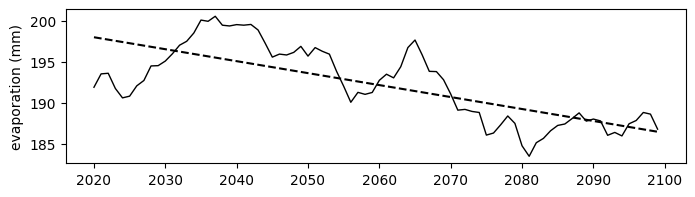

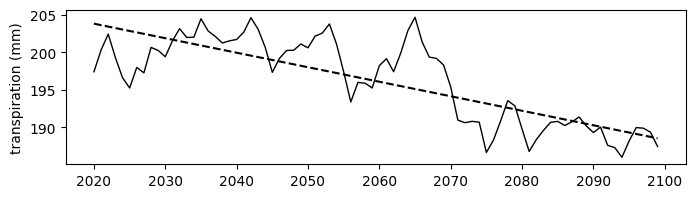

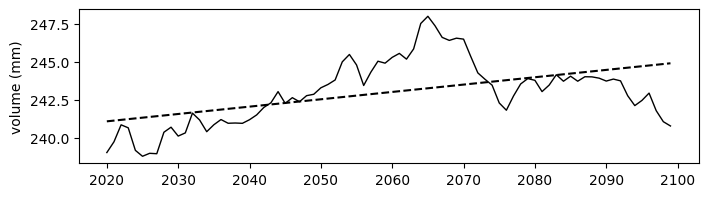

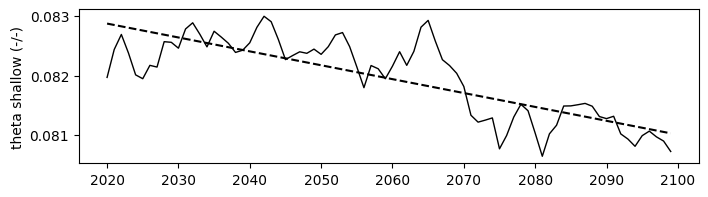

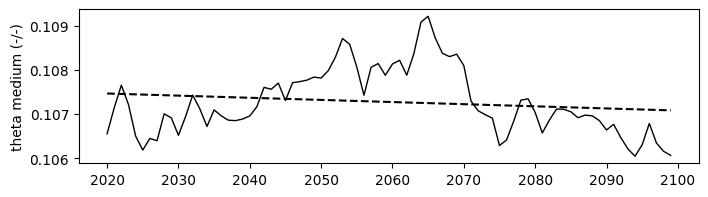

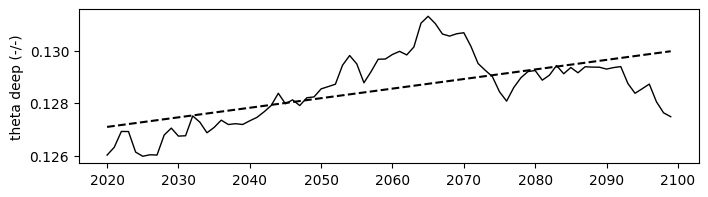

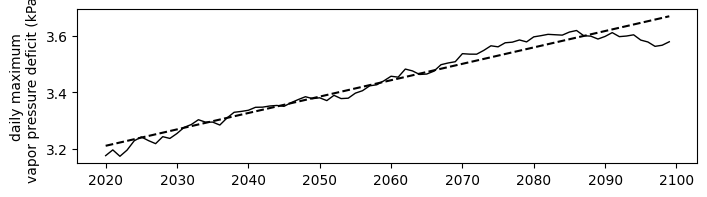

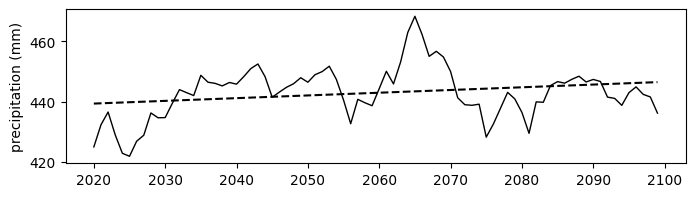

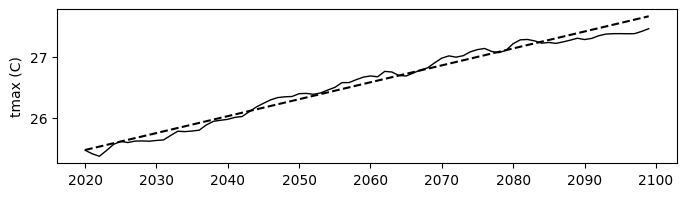

In [12]:
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import scipy
import pickle
import os

pcklFOLDER = '/content/drive/My Drive/Colab Notebooks/Empire'
#macaFILE = '/content/drive/My Drive/Colab Notebooks/Empire/MIROC5_timeseries.csv'
macaFILE = '/content/drive/My Drive/Colab Notebooks/Empire/CCSM4_timeseries.csv'
nodeFILE = '/content/drive/My Drive/Colab Notebooks/Empire/Obs_Node.out'
metFILE = '/content/drive/My Drive/Colab Notebooks/Empire/Meteo.out'
tlvlFILE = '/content/drive/My Drive/Colab Notebooks/Empire/T_Level.out'



###
'GEE Timeseries File'
###

df = pd.read_csv(macaFILE)

df['year'] = df['time'].apply(lambda x:int(str(x)[:4]))
df['month'] = df['time'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['time'].apply(lambda x:int(str(x)[6:8]))

pr_by_yr = df.groupby(df.year)['pr'].sum()
pr = pr_by_yr.rolling(window=40).mean()[39:]
#pr = pr_by_yr.rolling(window=10).mean()

tmax_by_yr = df.groupby(df.year)['tmax'].mean()
tmax = tmax_by_yr.rolling(window=40).mean()[39:]

df['tavg'] = df[['tmax', 'tmin']].mean(axis=1)
df['es'] = (6.1094*np.exp(1)**((17.625*(df['tavg']))/(df['tavg'] + 243.04)))*100.
df['e'] = df['rh']*df['es']/100.0
df['vapdef'] = df['es'] - df['e']

vapdef_by_year = df.groupby('year')['vapdef'].max().reset_index()
vapdef = vapdef_by_year['vapdef'].rolling(window=40).mean()[39:]



###
'Obs_Node.out'
###

###
'theta'
###

with open(nodeFILE) as f:
  lines = f.readlines()

data = []
for line in lines[11:]:
  if 'end' in line:
    break
  row = line.split()
  time = float(row[0])
  theta_s = float(row[5])
  theta_m = float(row[14])
  theta_d = float(row[23])
  data.append([time, theta_s, theta_m, theta_d])

node_df = pd.DataFrame(data=data, columns=['Time', 'theta_s', 'theta_m', 'theta_d'])

datestart = dt.datetime(year=1981, month=1, day=1)

theta_by_time = node_df.groupby(node_df['Time'])['theta_s'].mean().to_frame().reset_index()
theta_by_time['day'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
theta_by_time['month'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
theta_by_time['year'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
theta_by_time['weight'] = theta_by_time['theta_s']*(theta_by_time['Time'] - theta_by_time['Time'].shift(1))
theta_by_day = theta_by_time.groupby(['year', 'month', 'day'])['weight'].sum().reset_index()
theta_by_year = theta_by_day.groupby('year')['weight'].mean().reset_index()
theta_s = theta_by_year['weight'].rolling(window=40).mean()[39:-1]

theta_by_time = node_df.groupby(node_df['Time'])['theta_m'].mean().to_frame().reset_index()
theta_by_time['day'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
theta_by_time['month'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
theta_by_time['year'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
theta_by_time['weight'] = theta_by_time['theta_m']*(theta_by_time['Time'] - theta_by_time['Time'].shift(1))
theta_by_day = theta_by_time.groupby(['year', 'month', 'day'])['weight'].sum().reset_index()
theta_by_year = theta_by_day.groupby('year')['weight'].mean().reset_index()
theta_m = theta_by_year['weight'].rolling(window=40).mean()[39:-1]

theta_by_time = node_df.groupby(node_df['Time'])['theta_d'].mean().to_frame().reset_index()
theta_by_time['day'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
theta_by_time['month'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
theta_by_time['year'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
theta_by_time['weight'] = theta_by_time['theta_d']*(theta_by_time['Time'] - theta_by_time['Time'].shift(1))
theta_by_day = theta_by_time.groupby(['year', 'month', 'day'])['weight'].sum().reset_index()
theta_by_year = theta_by_day.groupby('year')['weight'].mean().reset_index()
theta_d = theta_by_year['weight'].rolling(window=40).mean()[39:-1]



###
'T_Level.out File'
###

###
'Evap'
###

tlvl_df = pd.read_csv(tlvlFILE, delim_whitespace=True, skiprows=[0, 1, 2, 3, 4, 5, 7, 8], skipfooter=1, engine='python')

datestart = dt.datetime(year=1981, month=1, day=1)

evap_by_time = tlvl_df.groupby(tlvl_df['Time'])['sum(Evap)'].mean().to_frame().reset_index()
evap_by_time['Evap'] = evap_by_time['sum(Evap)'] - evap_by_time['sum(Evap)'].shift(1)
evap_by_time['day'] = evap_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
evap_by_time['month'] = evap_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
evap_by_time['year'] = evap_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
evap_by_day = evap_by_time.groupby(['year', 'month', 'day'])['Evap'].sum().reset_index()
evap_by_year = evap_by_day.groupby('year')['Evap'].sum().reset_index()
evap = evap_by_year['Evap'].rolling(window=40).mean()[39:-1]

###
'Transp'
###

tlvl_df = pd.read_csv(tlvlFILE, delim_whitespace=True, skiprows=[0, 1, 2, 3, 4, 5, 7, 8], skipfooter=1, engine='python')

datestart = dt.datetime(year=1981, month=1, day=1)

tran_by_time = tlvl_df.groupby(tlvl_df['Time'])['vRoot'].mean().to_frame().reset_index()
tran_by_time['day'] = tran_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
tran_by_time['month'] = tran_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
tran_by_time['year'] = tran_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
tran_by_time['weight'] = tran_by_time['vRoot']*(tran_by_time['Time'] - tran_by_time['Time'].shift(1))
tran_by_day = tran_by_time.groupby(['year', 'month', 'day'])['weight'].sum().reset_index()
tran_by_year = tran_by_day.groupby('year')['weight'].sum().reset_index()
tran = tran_by_year['weight'].rolling(window=40).mean()[39:-1]

###
'hRoot'
###

tlvl_df = pd.read_csv(tlvlFILE, delim_whitespace=True, skiprows=[0, 1, 2, 3, 4, 5, 7, 8], skipfooter=1, engine='python')

datestart = dt.datetime(year=1981, month=1, day=1)

hroot_by_time = tlvl_df.groupby(tlvl_df['Time'])['hRoot'].mean().to_frame().reset_index()
hroot_by_time['day'] = hroot_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
hroot_by_time['month'] = hroot_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
hroot_by_time['year'] = hroot_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
hroot_by_time['weight'] = hroot_by_time['hRoot']*(hroot_by_time['Time'] - hroot_by_time['Time'].shift(1))
hroot_by_day = hroot_by_time.groupby(['year', 'month', 'day'])['weight'].sum().reset_index()/1000.
hroot_by_year = hroot_by_day.groupby('year')['weight'].min().reset_index()
hroot = hroot_by_year['weight'].rolling(window=40).mean()[40:-1]

###
'Soil Water Volume'
###

tlvl_df = pd.read_csv(tlvlFILE, delim_whitespace=True, skiprows=[0, 1, 2, 3, 4, 5, 7, 8], skipfooter=1, engine='python')

datestart = dt.datetime(year=1981, month=1, day=1)

vol_by_time = tlvl_df.groupby(tlvl_df['Time'])['Volume'].mean().to_frame().reset_index()
vol_by_time['day'] = vol_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
vol_by_time['month'] = vol_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
vol_by_time['year'] = vol_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
vol_by_time['weight'] = vol_by_time['Volume']*(vol_by_time['Time'] - vol_by_time['Time'].shift(1))
vol_by_day = vol_by_time.groupby(['year', 'month', 'day'])['weight'].sum().reset_index()
vol_by_year = vol_by_day.groupby('year')['weight'].mean().reset_index()
vol = vol_by_year['weight'].rolling(window=40).mean()[39:-1]

###
'Wilting Days based on hRoot'
###
"""
theta_r = 0.065
theta_s = 0.41
alpha = 7.5 #(1/m)
n = 1.89
m = 1.0 - (1.0/n)
h = abs(-1500000/(1000*9.80665)) #(Pa)
theta_wilt = theta_r + ((theta_s - theta_r)/(1+(h*alpha)**n)**m)
h_wilt = -300

values = hroot_by_day['weight'].values
hroot_by_day['wilt'] = [1 if v <= h_wilt else 0 for v in values]
wilt = hroot_by_day.groupby('year')['wilt'].sum().to_list()[39:-1]
"""

###
'Bottom Flux'
###
tlvl_df = pd.read_csv(tlvlFILE, delim_whitespace=True, skiprows=[0, 1, 2, 3, 4, 5, 7, 8], skipfooter=1, engine='python')

datestart = dt.datetime(year=1981, month=1, day=1)

vbot_by_time = tlvl_df.groupby(tlvl_df['Time'])['sum(vBot)'].mean().to_frame().reset_index()
vbot_by_time['vBot'] = vbot_by_time['sum(vBot)'] - vbot_by_time['sum(vBot)'].shift(1)
vbot_by_time['day'] = vbot_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
vbot_by_time['month'] = vbot_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
vbot_by_time['year'] = vbot_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
vbot_by_day = vbot_by_time.groupby(['year', 'month', 'day'])['vBot'].sum().reset_index()
vbot_by_year = vbot_by_day.groupby('year')['vBot'].sum().reset_index()
vbot = vbot_by_year['vBot'].rolling(window=40).mean()[39:-1]

###
'Meteo.out File'
###

###
'Precip'
###
"""
met_df = pd.read_csv(metFILE, delim_whitespace=True, skiprows=[0, 2, 3], skipfooter=1, engine='python')

datestart = dt.datetime(year=1981, month=1, day=1)

prec_by_time = met_df.groupby(met_df['Time'])['Prec'].mean().to_frame().reset_index()
prec_by_time['day'] = prec_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
prec_by_time['month'] = prec_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
prec_by_time['year'] = prec_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
prec_by_time['weight'] = prec_by_time['Prec']*(prec_by_time['Time'] - prec_by_time['Time'].shift(1))
prec_by_day = prec_by_time.groupby(['year', 'month', 'day'])['weight'].sum().reset_index()
prec_by_year = prec_by_day.groupby('year')['weight'].sum().reset_index()
prec = prec_by_year['weight'].rolling(window=40).mean()[39:-1]
"""

###
'Pot Evap'
###

met_df = pd.read_csv(metFILE, delim_whitespace=True, skiprows=[0, 2, 3], skipfooter=1, engine='python')

datestart = dt.datetime(year=1981, month=1, day=1)

evap_by_time = met_df.groupby(met_df['Time'])['Evap'].mean().to_frame().reset_index()
evap_by_time['day'] = evap_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
evap_by_time['month'] = evap_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
evap_by_time['year'] = evap_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
evap_by_time['weight'] = evap_by_time['Evap']*(evap_by_time['Time'] - evap_by_time['Time'].shift(1))
pot_evap_by_day = evap_by_time.groupby(['year', 'month', 'day'])['weight'].sum().reset_index()
pot_evap_by_year = pot_evap_by_day.groupby('year')['weight'].sum().reset_index()
pot_evap = pot_evap_by_year['weight'].rolling(window=40).mean()[39:-1]

###
'Pot Trans'
###

met_df = pd.read_csv(metFILE, delim_whitespace=True, skiprows=[0, 2, 3], skipfooter=1, engine='python')

datestart = dt.datetime(year=1981, month=1, day=1)

tran_by_time = met_df.groupby(met_df['Time'])['Transp'].mean().to_frame().reset_index()
tran_by_time['day'] = tran_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
tran_by_time['month'] = tran_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
tran_by_time['year'] = tran_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)
tran_by_time['weight'] = tran_by_time['Transp']*(tran_by_time['Time'] - tran_by_time['Time'].shift(1))
pot_tran_by_day = tran_by_time.groupby(['year', 'month', 'day'])['weight'].sum().reset_index()
pot_tran_by_year = pot_tran_by_day.groupby('year')['weight'].sum().reset_index()
pot_tran = pot_tran_by_year['weight'].rolling(window=40).mean()[39:-1]



###
'GRAPHS'
###

###
'root zone suction head'
###
"""
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), evap, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(evap)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('evaporation (mm)')
"""

###
'potential evaporation'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), pot_evap, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(pot_evap)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('pot. evaporation (mm)')

###
'potential transpiration'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), pot_tran, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(pot_tran)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('pot. transpiration (mm)')

###
'root zone suction head'
###
"""
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2099), hroot, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(hroot)
x = np.array([i for i, elem in enumerate(range(2020, 2099))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099], [slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('suction pressure head root zone (m)')
"""

###
'wilting days'
###
"""
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), wilt, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(wilt)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099], [slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('wilting days (days)')
"""
###
'evaporation'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), evap, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(evap)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('evaporation (mm)')

###
'transpiration'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), tran, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(tran)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('transpiration (mm)')

###
'soil storage volume'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), vol, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(vol)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('volume (mm)')

###
'theta shallow'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), theta_s, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(theta_s)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('theta shallow (-/-)')

###
'theta medium'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), theta_m, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(theta_m)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('theta medium (-/-)')

###
'theta deep'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), theta_d, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(theta_d)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('theta deep (-/-)')

###
'vapor pressure deficit'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), vapdef/1000.0, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(vapdef/1000.0)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('daily maximum\nvapor pressure deficit (kPa)')

###
'precip'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), pr, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(pr)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('precipitation (mm)')

###
'tmax'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), tmax, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(tmax)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('tmax (C)')



with open(os.path.join(pcklFOLDER, 'tmax.pkl'), 'wb') as f:
  pickle.dump(tmax, f)
with open(os.path.join(pcklFOLDER, 'pr.pkl'), 'wb') as f:
  pickle.dump(pr, f)
with open(os.path.join(pcklFOLDER, 'evap.pkl'), 'wb') as f:
  pickle.dump(evap, f)
with open(os.path.join(pcklFOLDER, 'tran.pkl'), 'wb') as f:
  pickle.dump(tran, f)
with open(os.path.join(pcklFOLDER, 'vapdef.pkl'), 'wb') as f:
  pickle.dump(vapdef/1000.0, f)


0.8762063858918627
878.5575603484903
70.08000000000004
0.8785749062592376
880.7464490529916
70.08000000000004


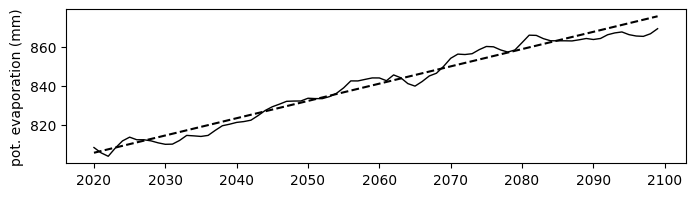

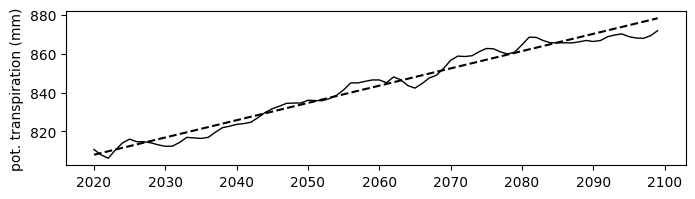

In [19]:
###
'potential evaporation'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), pot_evap, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(pot_evap)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('pot. evaporation (mm)')
print(slope)
print(y[0] + (80*.876))
print((y[0] + (80*.876)) - y[0])


###
'potential transpiration'
###
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(range(2020, 2100), pot_tran, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(pot_tran)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax.set_ylabel('pot. transpiration (mm)')
print(slope)
print(y[0] + (80*.876))
print((y[0] + (80*.876)) - y[0])


Text(0.05, 0.7, 'slope = 0.006 kPa/yr\nGCM = MIROC5\n40-year moving avg.')

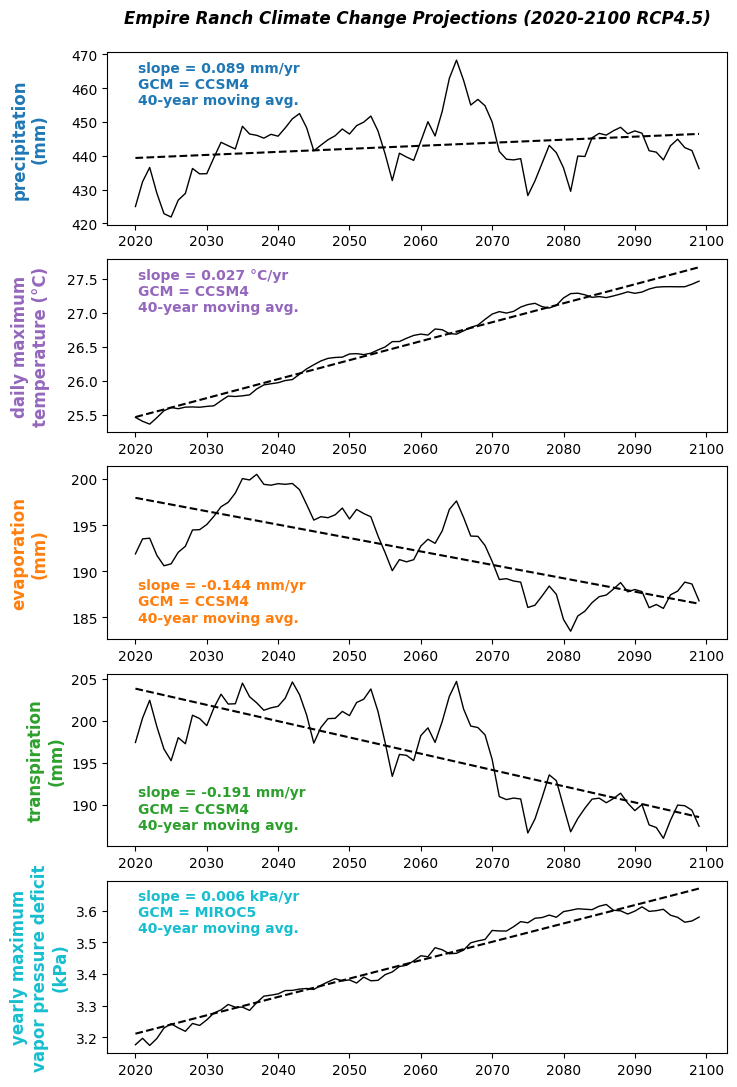

In [13]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

pcklFOLDER = '/content/drive/My Drive/Colab Notebooks/Empire'

with open(os.path.join(pcklFOLDER, 'tmax.pkl'), 'rb') as f:
  tmax = pickle.load(f)
with open(os.path.join(pcklFOLDER, 'pr.pkl'), 'rb') as f:
  pr = pickle.load(f)
with open(os.path.join(pcklFOLDER, 'evap.pkl'), 'rb') as f:
  evap = pickle.load(f)
with open(os.path.join(pcklFOLDER, 'tran.pkl'), 'rb') as f:
  tran = pickle.load(f)
with open(os.path.join(pcklFOLDER, 'vapdef_MIROC5.pkl'), 'rb') as f:
  vapdef = pickle.load(f)


fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, ncols=1, figsize=(8, 13))
ax0.set_title('Empire Ranch Climate Change Projections (2020-2100 RCP4.5)\n', fontweight='extra bold', style='oblique')

###
'precip'
###
ax0.plot(range(2020, 2100), pr, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(pr)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax0.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax0.set_ylabel('precipitation\n(mm)', size=12, color='tab:blue', fontweight='bold', labelpad=16)
ax0.text(0.05, 0.7, 'slope = {} mm/yr\nGCM = CCSM4\n40-year moving avg.'.format(round(slope, 3)), size=10, color='tab:blue', fontweight='bold', transform=ax0.transAxes)
###
'tmax'
###
ax1.plot(range(2020, 2100), tmax, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(tmax)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax1.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax1.set_ylabel('daily maximum\ntemperature (°C)', size=12, color='tab:purple', fontweight='bold', labelpad=12)
ax1.text(0.05, 0.7, 'slope = {} °C/yr\nGCM = CCSM4\n40-year moving avg.'.format(round(slope, 3)), size=10, color='tab:purple', fontweight='bold', transform=ax1.transAxes)
###
'evaporation'
###
ax2.plot(range(2020, 2100), evap, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(evap)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax2.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax2.set_ylabel('evaporation\n(mm)', size=12, color='tab:orange', fontweight='bold', labelpad=16)
ax2.text(0.05, 0.1, 'slope = {} mm/yr\nGCM = CCSM4\n40-year moving avg.'.format(round(slope, 3)), size=10, color='tab:orange', fontweight='bold', transform=ax2.transAxes)
###
'transpiration'
###
ax3.plot(range(2020, 2100), tran, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(tran)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax3.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax3.set_ylabel('transpiration\n(mm)', size=12, color='tab:green', fontweight='bold')
ax3.text(0.05, 0.1, 'slope = {} mm/yr\nGCM = CCSM4\n40-year moving avg.'.format(round(slope, 3)), size=10, color='tab:green', fontweight='bold', transform=ax3.transAxes)
###
'vapor pressure deficit'
###
ax4.plot(range(2020, 2100), vapdef, linestyle='-', color='black', linewidth=1, label='Ensemble Mean')
y = np.array(vapdef)
x = np.array([i for i, elem in enumerate(range(2020, 2100))])
res = scipy.stats.linregress(x, y, alternative='greater')
slope = res.slope
yint = res.intercept
ax4.plot([2020, 2099],[slope*0 + yint, slope*80 + yint], linestyle='--', color='black', zorder=-999)
ax4.set_ylabel('yearly maximum\nvapor pressure deficit\n(kPa)', size=12, color='tab:cyan', fontweight='bold')
ax4.text(0.05, 0.7, 'slope = {} kPa/yr\nGCM = MIROC5\n40-year moving avg.'.format(round(slope, 3)), size=10, color='tab:cyan', fontweight='bold', transform=ax4.transAxes)




In [14]:
import os
import pickle

pcklFOLDER = '/content/drive/My Drive/Colab Notebooks/Empire'
nodeFILE = '/content/drive/My Drive/Colab Notebooks/Empire/Obs_Node.out'

###
'Obs_Node.out'
###

###
'theta'
###

with open(nodeFILE) as f:
  lines = f.readlines()

data = []
for line in lines[11:]:
  if 'end' in line:
    break
  row = line.split()
  time = float(row[0])
  theta_a = float(row[2])
  theta_b = float(row[5])
  theta_c = float(row[8])
  theta_d = float(row[11])
  theta_e = float(row[14])
  theta_f = float(row[17])
  theta_g = float(row[20])
  theta_h = float(row[23])
  theta_i = float(row[26])
  theta_j = float(row[29])

  data.append([time, theta_a, theta_b, theta_c, theta_d, theta_e, theta_f, theta_g, theta_h, theta_i, theta_j])


with open(os.path.join(pcklFOLDER, 'theta_data.pkl'), 'wb') as f:
  pickle.dump(data, f)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.9/727.9 kB 6.7 MB/s eta 0:00:00


<ipython-input-15-bfb78379166a>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100])
<ipython-input-15-bfb78379166a>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.8, 0.6, 0.4, 0.2, 0.0])


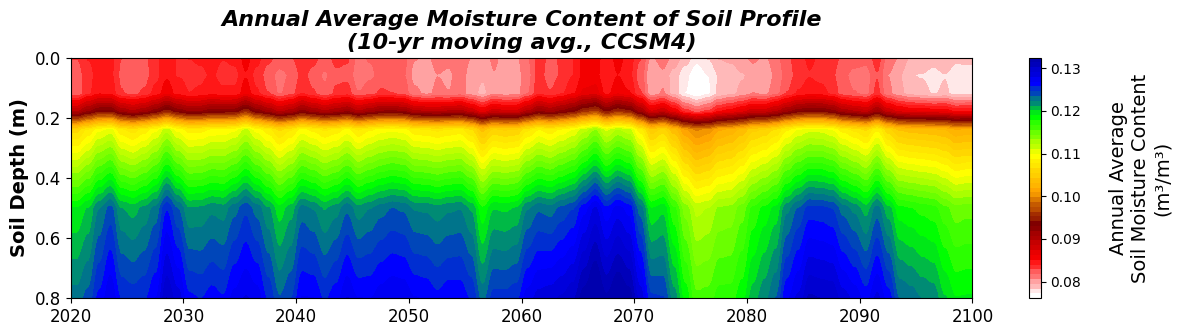

In [15]:
!pip install colormaps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import datetime as dt
from scipy.interpolate import LinearNDInterpolator
import os
import pickle
import colormaps as cmaps

pcklFOLDER = '/content/drive/My Drive/Colab Notebooks/Empire'

with open(os.path.join(pcklFOLDER, 'theta_data.pkl'), 'rb') as f:
  data = pickle.load(f)

theta_columns = ['theta_a', 'theta_b', 'theta_c', 'theta_d', 'theta_e', 'theta_f', 'theta_g', 'theta_h', 'theta_i', 'theta_j']
theta_w_columns = [s + '_w' for s in theta_columns]
#theta_depths = [0.0, 100.0, 200.0, 300.0, 500.0, 700.0, 900.0, 1200.0, 1500.0, 2000.0]
theta_depths = [0.0, 60.0, 120.0, 180.0, 240.0, 500.0, 800.0, 1200.0, 1600.0, 2000.0]
node_df = pd.DataFrame(data=data, columns=['Time'] + theta_columns)

datestart = dt.datetime(year=1981, month=1, day=1)

theta_by_time = node_df.groupby(node_df['Time'])[theta_columns].mean().reset_index()
theta_by_time['day'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).day)
theta_by_time['month'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).month)
theta_by_time['year'] = theta_by_time['Time'].apply(lambda x: (datestart + dt.timedelta(seconds=x*86400)).year)

theta_by_time['dayfrac'] = theta_by_time['Time'] - theta_by_time['Time'].shift(1)
theta_by_time[theta_w_columns] = theta_by_time[theta_columns].multiply(theta_by_time['dayfrac'], axis='index')

theta_by_day = theta_by_time.groupby(['year', 'month', 'day'])[theta_w_columns].sum().reset_index()
theta_by_year = theta_by_day.groupby('year')[theta_w_columns].mean().reset_index()
#theta = theta_by_year[theta_w_columns].rolling(window=40).mean()[39:-1]
#theta = theta_by_year[theta_w_columns].rolling(window=30).mean()[39:-1]
#theta = theta_by_year[theta_w_columns].rolling(window=20).mean()[39:-1]
theta = theta_by_year[theta_w_columns].rolling(window=10).mean()[39:-1]
#theta = theta_by_year[theta_w_columns][39:-1]

theta_array = np.empty(shape=(2000, 80))

x_list, y_list, z_list = [], [], []
for i, column in enumerate(theta):
  yearly_theta = theta[column].values
  y = int(theta_depths[i])*-1
  for x, z in enumerate(yearly_theta):
    x_list.append(float(x))
    y_list.append(float(y))
    z_list.append(float(z))

X = np.linspace(0, 79, 80)
Y = np.linspace(0, -1999, 2000)
Y = Y[:800]
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(figsize=(12, 3))
fig.tight_layout()
interp = LinearNDInterpolator(list(zip(x_list, y_list)), z_list)
Z = interp(X, Y)
im = ax.imshow(Z, cmap=cmaps.WhViBlGrYeOrReWh_r.shift(-0.75), vmin=min(z_list), vmax=0.1325, extent=[0, 80, -800, 0], aspect='auto')
ax.set_xlim(0, 80)
ax.set_xbound(0, 80)
ax.set_xticklabels([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100])
plt.locator_params(axis='y', nbins=5)
ax.set_yticklabels([0.8, 0.6, 0.4, 0.2, 0.0])
ax.set_ylabel('Soil Depth (m)', size=14, fontweight='bold')
ax.set_title('Annual Average Moisture Content of Soil Profile\n(10-yr moving avg., CCSM4)', size=16, fontweight='extra bold', style='oblique')
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim(-800, 0)
ax.set_ybound(-800, 0)
fig.colorbar(im, orientation='vertical', pad=0.05).set_label(label='\nAnnual Average\nSoil Moisture Content\n(m³/m³)', size=14)
fig.show()




